In [668]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [669]:
!ls

prediction.xlsx		submission	 Test1.ipynb  Test.csv
Sample_Submission.xlsx	submission.xlsx  Test2.ipynb  Train.csv


In [670]:
df_train=pd.read_csv("Train.csv")
df_test=pd.read_csv("Test.csv")

In [671]:
df_train.shape

(947, 54)

In [672]:
combined=pd.concat([df_train,df_test])

### Feature Selection

In [673]:
df_train.columns

Index(['Freq_Of_Word_1', 'Freq_Of_Word_2', 'Freq_Of_Word_3', 'Freq_Of_Word_4',
       'Freq_Of_Word_5', 'Freq_Of_Word_6', 'Freq_Of_Word_7', 'Freq_Of_Word_8',
       'Freq_Of_Word_9', 'Freq_Of_Word_10', 'Freq_Of_Word_11',
       'Freq_Of_Word_12', 'Freq_Of_Word_13', 'Freq_Of_Word_14',
       'Freq_Of_Word_15', 'Freq_Of_Word_16', 'Freq_Of_Word_17',
       'Freq_Of_Word_18', 'Freq_Of_Word_19', 'Freq_Of_Word_20',
       'Freq_Of_Word_21', 'Freq_Of_Word_22', 'Freq_Of_Word_23',
       'Freq_Of_Word_24', 'Freq_Of_Word_25', 'Freq_Of_Word_26',
       'Freq_Of_Word_27', 'Freq_Of_Word_28', 'Freq_Of_Word_29',
       'Freq_Of_Word_30', 'Freq_Of_Word_31', 'Freq_Of_Word_32',
       'Freq_Of_Word_33', 'Freq_Of_Word_34', 'Freq_Of_Word_35',
       'Freq_Of_Word_36', 'Freq_Of_Word_37', 'Freq_Of_Word_38',
       'Freq_Of_Word_39', 'Freq_Of_Word_40', 'Freq_Of_Word_41',
       'Freq_Of_Word_42', 'Freq_Of_Word_43', 'Freq_Of_Word_44',
       'Freq_Of_Word_45', 'Freq_Of_Word_46', 'Freq_Of_Word_47',
       'Fre

In [638]:
combined["Freq_Of_Word_4"].idxmax(axis=1)
#combined["Freq_Of_Word_4"].

339

In [674]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [675]:
selector = VarianceThreshold()
selector.fit_transform(combined)

selector.variances_

array([1.05019584, 1.10813495, 1.04009692, 1.16302118, 1.04499575,
       1.11351481, 0.84384564, 0.97457712, 1.15050515, 1.02784015,
       1.13897482, 0.99790038, 0.79057837, 1.05025953, 0.97731159,
       0.77687699, 1.00270051, 0.99687213, 0.989891  , 1.07608848,
       1.03037188, 0.9689125 , 0.89280485, 0.65123825, 0.9713756 ,
       1.08543957, 1.09945962, 1.07171636, 1.03083154, 0.86484648,
       0.58342768, 0.99954868, 1.08798099, 0.9999672 , 0.97579573,
       1.00389159, 0.99471151, 1.41176971, 1.1054026 , 0.97384859,
       1.19151115, 1.19369009, 0.97433373, 1.3358072 , 1.18685989,
       1.11526707, 0.85729152, 1.2525901 , 1.11675375, 0.68814486,
       1.14003084, 0.3122821 , 0.81258887, 0.23758905])

In [641]:
varModel=VarianceThreshold(threshold=(.8 * (1 - .8))) #Setting variance threshold to 0 which means features that have same value in all samples.
varModel.fit(df_test)
constArr=varModel.get_support()
constArr

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [642]:
quasiModel=VarianceThreshold(threshold=(.8 * (1 - .8)))
 #It will search for the features having 99% of same value in all samples.
quasiModel.fit(combined)

VarianceThreshold(threshold=0.15999999999999998)

In [643]:
quasiArr=quasiModel.get_support()
quasiArr

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

## Duplicate columns

In [644]:
def duplicateColumns(data):
    dupliCols=[]
    for i in range(0,len(data.columns)):
        col1=data.columns[i]
        for col2 in data.columns[i+1:]:
            if data[col1].equals(data[col2]):
                dupliCols.append(col1+','+col2)
    return dupliCols

In [645]:
duplCols=duplicateColumns(combined)
duplCols

[]

## Correlation columns

In [676]:
def correlation(dataset,threshold):
    col_corr=set() # set will contains unique values.
    corr_matrix=dataset.corr() #finding the correlation between columns.
    for i in range(len(corr_matrix.columns)): #number of columns
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking the correlation between columns.
                colName=corr_matrix.columns[i] #getting the column name
                col_corr.add(colName) #adding the correlated column name heigher than threshold value.
    return col_corr #returning set of column names
col=correlation(combined,0.6)
print('Correlated columns:',col)

Correlated columns: {'Freq_Of_Word_32', 'Freq_Of_Word_40', 'LengthOFFirstParagraph', 'Freq_Of_Word_31', 'Freq_Of_Word_35', 'Freq_Of_Word_36', 'Freq_Of_Word_34'}


In [677]:
scol=correlation(combined,0.75)
print('Correlated columns:',scol)
combined=combined.drop(columns=scol,axis=1)


Correlated columns: {'Freq_Of_Word_32', 'Freq_Of_Word_40', 'Freq_Of_Word_34'}


## Unique values columns

In [619]:
# def identify_single_unique(data):
#     """Identifies features with only a single unique value. NaNs do not count as a unique value. """
#     removal_ops = {}
        
#     # Calculate the unique counts in each column
#     unique_counts = data.nunique()

#     unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})

#     # Find the columns with only one unique count
#     record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})

#     to_drop = list(record_single_unique['feature'])

#     record_single_unique = record_single_unique
#     removal_ops['single_unique'] = to_drop

#     print('%d features with a single unique value.\n' % len(removal_ops['single_unique']))


In [620]:
identify_single_unique(combined)

0 features with a single unique value.



## Feature Selection SKlearn

In [530]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [678]:
df_train=combined.iloc[:947,]
Y = df_train['IsGoodNews']
X = df_train.drop('IsGoodNews', axis=1)

In [532]:
# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(X,Y)

In [533]:
#X_train=X_train.drop(columns=scol,axis=1)
#X_test=X_test.drop(columns=scol,axis=1)


In [534]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import SVC, LinearSVC

## Modelling

In [535]:
# df_train=pd.read_csv("Train.csv")
# df_test=pd.read_csv("Test.csv")
# combined=pd.concat([df_train,df_test])

In [572]:
df_train=combined.iloc[:947,]
df_test=combined.iloc[947:,]
#df_train.drop(["IsGoodNews"],axis=1,inplace=True)
#df_train["IsGoodNews"]=df_train["IsGoodNews"].astype(int)

In [665]:
X_train, X_test, Y_train, Y_test = train_test_split(df_train.drop(labels=['IsGoodNews'], axis=1),df_train['IsGoodNews'],test_size=0.3,random_state=0)

In [666]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

logreg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors = 3)
xgb=XGBClassifier()
gaussian = GaussianNB()
linear_svc = LinearSVC()
decision_tree = DecisionTreeClassifier()
#perceptron = Perceptron(max_iter=5)
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()


models = [logreg,knn,gaussian, linear_svc,rf, gboost,xgb,decision_tree ]
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    #score = compute_score(clf=model, X=X_train, y=Y_train, scoring='accuracy')
    model.fit(X_train,Y_train)
    score=round(model.score(X_test, Y_test) * 100, 2)
    predictions = model.predict(X_test)
    accuracy = f1_score(Y_test, predictions)
    print ('CV score = {0}'.format(score))
    print ('F1 Score score = {0}'.format(accuracy))



Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 91.23
F1 Score score = 0.8858447488584474
Cross-validation of : <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
CV score = 85.96
F1 Score score = 0.8165137614678899
Cross-validation of : <class 'sklearn.naive_bayes.GaussianNB'>
CV score = 84.21
F1 Score score = 0.830188679245283
Cross-validation of : <class 'sklearn.svm._classes.LinearSVC'>
CV score = 91.58
F1 Score score = 0.8909090909090909
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 93.33
F1 Score score = 0.914798206278027
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 92.28
F1 Score score = 0.9017857142857143
Cross-validation of : <class 'xgboost.sklearn.XGBClassifier'>
CV score = 92.98
F1 Score score = 0.9107142857142857
Cross-validation of : <class 'sklearn.tree._classes.DecisionTreeClassifier'>
CV score = 84.91
F1 Score score = 0.8

## LIGHTGBM

In [266]:
# Y_train = df_train['IsGoodNews']
# X_train = df_train.drop('IsGoodNews', axis=1)

In [501]:
d_train = lgb.Dataset(X_train, label=Y_train)

In [539]:
# params = {}
# params['learning_rate'] = 0.1
# params['boosting_type'] = 'gbdt'
# params['objective'] = 'binary'
# params['metric'] = 'binary_logloss'
# params['sub_feature'] = 1
# params['num_leaves'] = 10
# params['min_data'] = 2
# params['max_depth'] = 6
#clf = lgb.train(params, d_train, 200)
# prediction=pd.DataFrame(clf.predict(df_test.drop(["IsGoodNews"],axis=1)),columns=['IsGoodNews'])
# #score=f1_score(Y_test,prediction)


## Feature Importance

In [540]:
# model.get_score(importance_type='gain')

In [667]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
thresholds = sort(model.feature_importances_)
#thresholds=0.0001
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier(n_estimators=800,max_depth=6)
	selection_model.fit(select_X_train, Y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	predictions = selection_model.predict(select_X_test)
	accuracy = f1_score(Y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.000, n=53, Accuracy: 91.82%
Thresh=0.001, n=34, Accuracy: 91.40%
Thresh=0.003, n=33, Accuracy: 89.29%
Thresh=0.005, n=32, Accuracy: 90.58%
Thresh=0.005, n=31, Accuracy: 89.69%
Thresh=0.005, n=30, Accuracy: 89.78%
Thresh=0.005, n=29, Accuracy: 89.78%
Thresh=0.006, n=28, Accuracy: 88.79%
Thresh=0.006, n=27, Accuracy: 89.29%
T

In [327]:
selection = SelectFromModel(model, threshold=0.00001, prefit=True)
X_train = selection.transform(X_train)
X_test= selection.transform(X_test)

In [328]:
X_train.shape

(662, 50)

In [331]:
rf = XGBClassifier(n_estimators=800, random_state=1, max_depth=6)
rf.fit(X_train,Y_train)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [332]:
predictions = rf.predict(X_test)
print(f1_score(Y_test, predictions))


0.9181818181818182


In [339]:
importance = rf.get_fscore(fmap='xgb.fmap')

AttributeError: 'XGBClassifier' object has no attribute 'get_fscore'

<Figure size 1440x720 with 0 Axes>

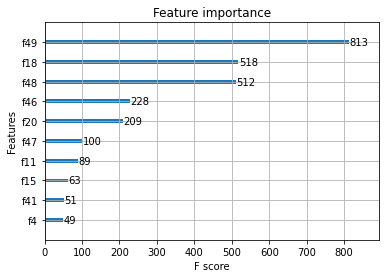

In [342]:
from xgboost import plot_importance
plt.figure(figsize=(20,10))
plot_importance(rf, max_num_features=10)

In [150]:
#plot_importance(rf, height=1)


[0.0421056  0.03365225 0.28152325 0.         0.04545466 0.01109459
 0.1605326  0.         0.04374242 0.00536232 0.00563397 0.
 0.         0.         0.00516189 0.0232725  0.00287083 0.00599515
 0.00625383 0.         0.00569206 0.         0.         0.01974096
 0.06505574 0.         0.00572417 0.00636019 0.02331181 0.04262243
 0.02999101 0.12884577]


In [650]:
df_train=combined.iloc[:947,]
df_test=combined.iloc[947:,]
#df_train.drop(["IsGoodNews"],axis=1,inplace=True)
#df_train["IsGoodNews"]=df_train["IsGoodNews"].astype(int)

In [651]:
Y_train = df_train['IsGoodNews']
X_train = df_train.drop('IsGoodNews', axis=1)

In [652]:
X_test=df_test.copy()

In [653]:
df_train.shape

(947, 51)

In [654]:

rf = XGBClassifier()
rf.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [655]:
score=round(rf.score(X_test, Y_test) * 100, 2)

ValueError: feature_names mismatch: ['Freq_Of_Word_1', 'Freq_Of_Word_2', 'Freq_Of_Word_3', 'Freq_Of_Word_4', 'Freq_Of_Word_5', 'Freq_Of_Word_6', 'Freq_Of_Word_7', 'Freq_Of_Word_8', 'Freq_Of_Word_9', 'Freq_Of_Word_10', 'Freq_Of_Word_11', 'Freq_Of_Word_12', 'Freq_Of_Word_13', 'Freq_Of_Word_14', 'Freq_Of_Word_15', 'Freq_Of_Word_16', 'Freq_Of_Word_17', 'Freq_Of_Word_18', 'Freq_Of_Word_19', 'Freq_Of_Word_20', 'Freq_Of_Word_21', 'Freq_Of_Word_22', 'Freq_Of_Word_23', 'Freq_Of_Word_24', 'Freq_Of_Word_25', 'Freq_Of_Word_26', 'Freq_Of_Word_27', 'Freq_Of_Word_28', 'Freq_Of_Word_29', 'Freq_Of_Word_30', 'Freq_Of_Word_31', 'Freq_Of_Word_33', 'Freq_Of_Word_35', 'Freq_Of_Word_36', 'Freq_Of_Word_37', 'Freq_Of_Word_38', 'Freq_Of_Word_39', 'Freq_Of_Word_41', 'Freq_Of_Word_42', 'Freq_Of_Word_43', 'Freq_Of_Word_44', 'Freq_Of_Word_45', 'Freq_Of_Word_46', 'Freq_Of_Word_47', 'Freq_Of_Word_48', 'Freq_Of_Word_49', 'Freq_Of_Word_50', 'TotalEmojiCharacters', 'LengthOFFirstParagraph', 'StylizedLetters'] ['Freq_Of_Word_1', 'Freq_Of_Word_2', 'Freq_Of_Word_3', 'Freq_Of_Word_4', 'Freq_Of_Word_5', 'Freq_Of_Word_6', 'Freq_Of_Word_7', 'Freq_Of_Word_8', 'Freq_Of_Word_9', 'Freq_Of_Word_10', 'Freq_Of_Word_11', 'Freq_Of_Word_12', 'Freq_Of_Word_13', 'Freq_Of_Word_14', 'Freq_Of_Word_15', 'Freq_Of_Word_16', 'Freq_Of_Word_17', 'Freq_Of_Word_18', 'Freq_Of_Word_19', 'Freq_Of_Word_20', 'Freq_Of_Word_21', 'Freq_Of_Word_22', 'Freq_Of_Word_23', 'Freq_Of_Word_24', 'Freq_Of_Word_25', 'Freq_Of_Word_26', 'Freq_Of_Word_27', 'Freq_Of_Word_28', 'Freq_Of_Word_29', 'Freq_Of_Word_30', 'Freq_Of_Word_31', 'Freq_Of_Word_33', 'Freq_Of_Word_35', 'Freq_Of_Word_36', 'Freq_Of_Word_37', 'Freq_Of_Word_38', 'Freq_Of_Word_39', 'Freq_Of_Word_41', 'Freq_Of_Word_42', 'Freq_Of_Word_43', 'Freq_Of_Word_44', 'Freq_Of_Word_45', 'Freq_Of_Word_46', 'Freq_Of_Word_47', 'Freq_Of_Word_48', 'Freq_Of_Word_49', 'Freq_Of_Word_50', 'TotalEmojiCharacters', 'LengthOFFirstParagraph', 'StylizedLetters', 'IsGoodNews']
training data did not have the following fields: IsGoodNews

In [220]:
#print('Random Forests roc-auc: {}'.format(roc_auc_score(Y_test, pred[:,1])))

In [208]:
#

In [656]:
##SUbmission

# y
pred = rf.predict(df_test.drop(["IsGoodNews"],axis=1))
submission=pd.DataFrame(pred,columns=["IsGoodNews"])
submission.to_excel("submission.xlsx")